# MNIST Classification Showdown

# 0. Imports and Datasets

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax

In [1]:
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque
from tqdm import trange

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from bayes_opt import BayesianOptimization

jax.numpy.set_printoptions(suppress = True, precision=4)
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
from rebayes.sgd_filter import replay_sgd as rsgd
import demos.showdown.hparam_tune_clf as hp

/home/peter0414/rebayes/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-06 02:43:57.336359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-06 02:43:58.074479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-06 02:43:58.074589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [2]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds

In [3]:
train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

2023-03-06 02:44:04.754064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-06 02:44:04.754101: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
X_train, y_train = jnp.array(train_ds['image']), jnp.array(train_ds['label'])
X_test, y_test = jnp.array(test_ds['image']), jnp.array(test_ds['label'])

In [5]:
# Reshape data
X_train = X_train.reshape(-1, 1, 28, 28, 1)
y_train_ohe = jax.nn.one_hot(y_train, 10)

# 1. Models

In [6]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [7]:
cnn = CNN()
key = jr.PRNGKey(0)
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
flat_params, unflatten_fn = ravel_pytree(params)
print(f'Params size = {flat_params.shape}')
state_dim = flat_params.shape[0]

Params size = (421642,)


In [8]:
apply_fn = lambda w, x: cnn.apply({'params': unflatten_fn(w)}, x).ravel()
emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

In [9]:
test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}

In [10]:
def evaluate_neg_log_likelihood(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

In [11]:
def evaluate_miscl(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_miscl(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        acc_test = (logits.argmax(axis=-1) == label).mean()
        return 1.0 - acc_test
    miscls = vmap(evaluate_miscl, (0, 0))(test_set['label'], test_set['image'])
    return miscls.mean()

In [12]:
def nll_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    nll = evaluate_neg_log_likelihood(bel.mean, unflatten_fn, apply_fn, test_set)
    return nll

In [13]:
def miscl_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    miscl = evaluate_miscl(bel.mean, unflatten_fn, apply_fn, test_set)
    return miscl

In [14]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

# 2. Orth-SVD LoFi

## 2.1 Hyperparam Tuning

In [106]:
def lofi_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, memory_size, method='lofi_orth', diag_cov=False):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    lofi_params = LoFiParams(
        memory_size=int(memory_size),
        diagonal_covariance=diag_cov,
    )
    estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=nll_callback, progress_bar=False, **test_kwargs)
    result = -output.mean()
    if jnp.isnan(result):
        result = -1e6

    return result

In [107]:
os_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='lofi_orth', diag_cov=False)
os_lofi_optimizer = BayesianOptimization(
    f=os_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, 0),
        'log_dynamics_cov': (-8, 0),
        'log_alpha': (-8, 0),
    }
)

In [108]:
os_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -7.755e+0 | -1.42     | -0.5036   | -4.14     |
| 2         | -30.42    | -3.167    | -0.3738   | -2.62     |
| 3         | -1.175    | -6.297    | -6.776    | -1.07     |
| 4         | -2.112    | -1.685    | -3.393    | -7.98     |
| 5         | -769.5    | -0.2203   | -2.133    | -4.503    |
| 6         | -1.479    | -2.445    | -4.914    | -1.46     |
| 7         | -2.286    | -5.391    | -7.672    | -4.488    |
| 8         | -2.279    | -4.043    | -7.936    | -4.218    |
| 9         | -38.29    | -4.918    | -2.951    | -6.709    |
| 10        | -1.702    | -3.898    | -7.547    | -2.712    |
| 11        | -1.443e+0 | -0.6042   | -1.428    | -4.905    |
| 12        | -4.834e+0 | -0.1091   | -2.06     | -7.58     |
| 13        | -7.342    | -1.5      | -2.614    | -6.582    |
| 14        | -1.888    | -2.253    | -4.887    | -3.39     |
| 15    

In [109]:
# 'log_alpha': -6.296828177792687, 'log_dynamics_cov': -6.775925627130752, 'log_init_cov': -1.0702485048743968
print(os_lofi_optimizer.max)

{'target': -1.1753770112991333, 'params': {'log_alpha': -6.296828177792687, 'log_dynamics_cov': -6.775925627130752, 'log_init_cov': -1.0702485048743968}}


## 2.2 Test-Set NLL Evaluation

In [90]:
def evaluate_model(estimator, X, y, test_kwargs, key=0, n_steps=1_000, n_iter=10, callback=nll_callback, bel=None):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = estimator.scan(X_curr, y_curr, callback=callback, **test_kwargs, progress_bar=True, bel=bel)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [95]:
init_cov = jnp.power(10, -1.0702485048743968)
dynamics_cov = jnp.power(10, -6.775925627130752)
alpha = jnp.power(10, -6.296828177792687)
method = 'lofi_orth'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
os_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:33<00:00, 29.57it/s]


In [96]:
os_lofi_mean, os_lofi_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs)

In [97]:
os_lofi_miscl_mean, os_lofi_miscl_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations:  25%|██▌       | 250/1000 [00:08<00:29, 25.72it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:43<00:00, 22.81it/s]


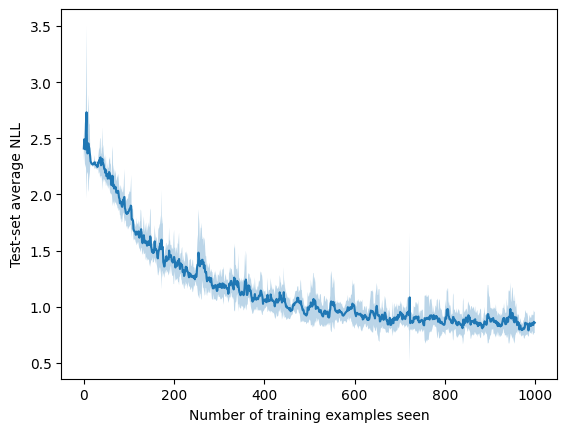

In [98]:
fig, ax = plt.subplots()
ax.plot(os_lofi_mean)
ax.fill_between(
    jnp.arange(os_lofi_mean.shape[0]),
    os_lofi_mean - os_lofi_std,
    os_lofi_mean + os_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

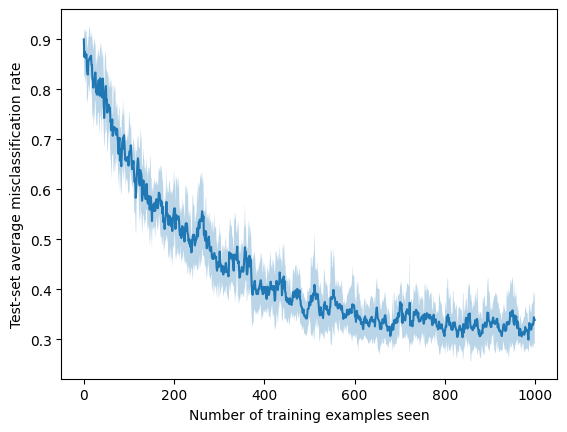

In [99]:
fig, ax = plt.subplots()
ax.plot(os_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(os_lofi_miscl_mean.shape[0]),
    os_lofi_miscl_mean - os_lofi_miscl_std,
    os_lofi_miscl_mean + os_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 3. Full-SVD LoFi

## 3.1 Hyperparam Tuning

In [158]:
fs_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='lofi', diag_cov=False)
fs_lofi_optimizer = BayesianOptimization(
    f=fs_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, 0),
        'log_dynamics_cov': (-8, 0),
        'log_alpha': (-8, 0),
    }
)

In [159]:
fs_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -931.4    | -2.538    | -0.4083   | -1.214    |
| 2         | -7.296    | -3.192    | -3.166    | -3.634    |
| 3         | -1.614    | -7.489    | -5.085    | -7.316    |
| 4         | -9.827e+0 | -1.578    | -1.423    | -0.5546   |
| 5         | -2.263    | -3.006    | -6.333    | -6.21     |
| 6         | -7.469e+0 | -1.191    | -0.3997   | -6.955    |
| 7         | -1.195    | -7.103    | -5.916    | -0.6051   |
| 8         | -7.356e+0 | -2.732    | -0.777    | -1.17     |
| 9         | -1.228    | -6.675    | -4.214    | -7.507    |
| 10        | -2.24     | -1.303    | -4.915    | -3.071    |
| 11        | -0.9798   | -6.304    | -6.075    | -1.032    |
| 12        | -60.34    | -1.428    | -2.665    | -1.014    |
| 13        | -22.91    | -6.468    | -3.112    | -6.136    |
| 14        | -15.07    | -5.486    | -3.155    | -7.203    |
| 15    

In [160]:
# 'log_alpha': -6.496032003182814, 'log_dynamics_cov': -5.569711627074242, 'log_init_cov': -1.0362337325001931
print(fs_lofi_optimizer.max)

{'target': -0.9672799706459045, 'params': {'log_alpha': -6.496032003182814, 'log_dynamics_cov': -5.569711627074242, 'log_init_cov': -1.0362337325001931}}


## 3.2 Test-Set NLL Evaluation

In [102]:
init_cov = jnp.power(10, -1.0362337325001931)
dynamics_cov = jnp.power(10, -5.569711627074242)
alpha = jnp.power(10, -6.496032003182814)
method = 'lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
fs_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [103]:
fs_lofi_mean, fs_lofi_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs)

In [104]:
fs_lofi_miscl_mean, fs_lofi_miscl_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations:  20%|██        | 200/1000 [00:08<00:35, 22.23it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s]


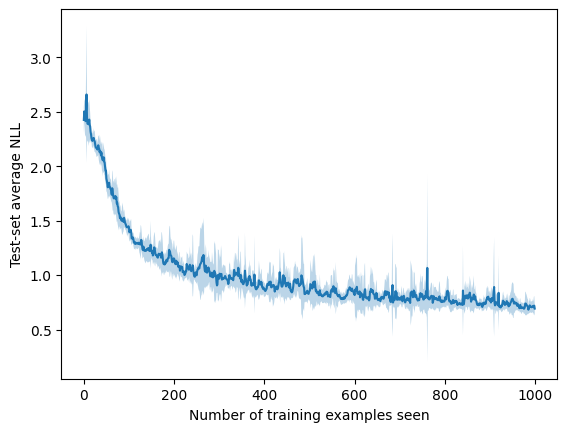

In [105]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_mean)
ax.fill_between(
    jnp.arange(fs_lofi_mean.shape[0]),
    fs_lofi_mean - fs_lofi_std,
    fs_lofi_mean + fs_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

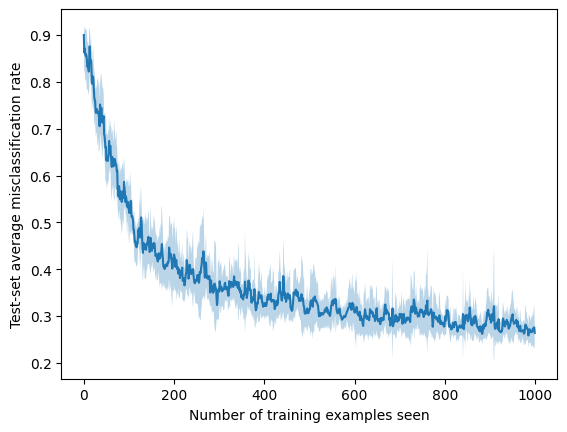

In [106]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(fs_lofi_miscl_mean.shape[0]),
    fs_lofi_miscl_mean - fs_lofi_miscl_std,
    fs_lofi_miscl_mean + fs_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 4. Generalized LoFi

## 4.1 Hyperparam Tuning

In [172]:
g_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='lofi', diag_cov=True)
g_lofi_optimizer = BayesianOptimization(
    f=g_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-8, 0),
        'log_dynamics_cov': (-8, 0),
        'log_alpha': (-8, 0),
    }
)

In [173]:
g_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -811.7    | -5.525    | -2.8      | -1.342    |
| 2         | -1.196    | -7.149    | -3.552    | -7.848    |
| 3         | -43.13    | -6.392    | -1.105    | -5.44     |
| 4         | -2.148    | -4.673    | -5.792    | -5.766    |
| 5         | -2.294    | -2.57     | -7.31     | -7.135    |
| 6         | -2.263    | -5.097    | -6.422    | -6.725    |
| 7         | -250.6    | -1.101    | -1.846    | -0.3517   |
| 8         | -2.24     | -1.519    | -5.133    | -4.554    |
| 9         | -3.503    | -1.211    | -2.93     | -3.383    |
| 10        | -174.5    | -1.26     | -2.047    | -7.636    |
| 11        | -9.091    | -3.29     | -2.195    | -0.09065  |
| 12        | -2.082    | -7.67     | -5.669    | -4.994    |
| 13        | -89.19    | -6.801    | -2.148    | -7.357    |
| 14        | -18.0     | -0.4015   | -2.532    | -6.843    |
| 15    

In [174]:
# 'log_alpha': -6.960759093672885, 'log_dynamics_cov': -6.81159254334887, 'log_init_cov': -0.9580018111776233
print(g_lofi_optimizer.max)

{'target': -0.958186686038971, 'params': {'log_alpha': -6.960759093672885, 'log_dynamics_cov': -6.81159254334887, 'log_init_cov': -0.9580018111776233}}


## 4.2 Test-Set NLL Evaluation

In [107]:
init_cov = jnp.power(10, -0.9580018111776233)
dynamics_cov = jnp.power(10, -6.81159254334887)
alpha = jnp.power(10, -6.960759093672885)
method = 'lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=True
)
g_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [108]:
g_lofi_mean, g_lofi_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs)

In [109]:
g_lofi_miscl_mean, g_lofi_miscl_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

Running for 1,000 iterations:  20%|██        | 200/1000 [00:10<00:45, 17.61it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:09<00:00, 14.43it/s]


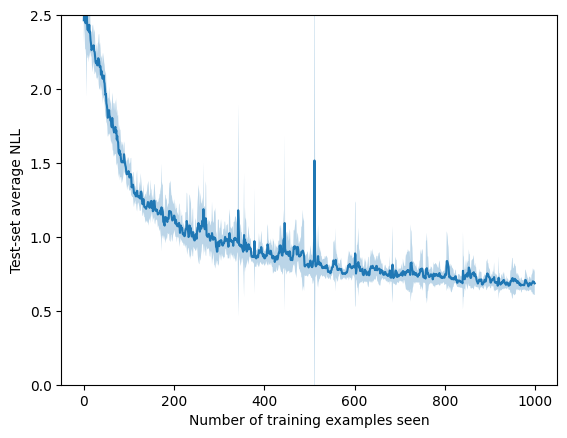

In [110]:
fig, ax = plt.subplots()
ax.plot(g_lofi_mean)
ax.fill_between(
    jnp.arange(g_lofi_mean.shape[0]),
    g_lofi_mean - g_lofi_std,
    g_lofi_mean + g_lofi_std,
    alpha=0.3
)
ax.set_ylim(0.0, 2.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

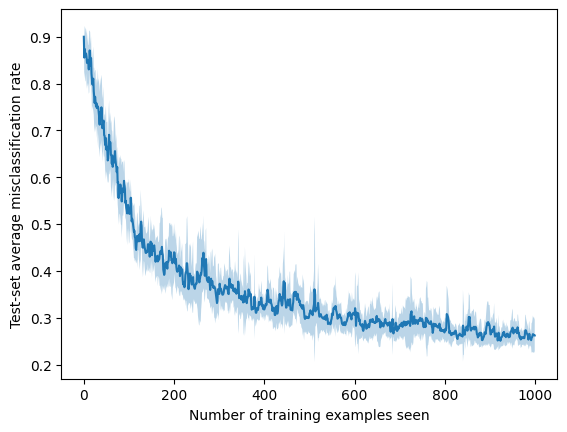

In [111]:
fig, ax = plt.subplots()
ax.plot(g_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(g_lofi_miscl_mean.shape[0]),
    g_lofi_miscl_mean - g_lofi_miscl_std,
    g_lofi_miscl_mean + g_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 5. FD-EKF

## 5.1 Hyperparam Tuning

In [116]:
def ekf_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, method='fdekf'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    estimator = RebayesEKF(model_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=nll_callback, progress_bar=False, **test_kwargs)
    
    result = -output.mean()
    if jnp.isnan(result):
        result = -1e6
    return result

In [117]:
fdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='fdekf')
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-8, 0),
        'log_dynamics_cov': (-8, 0),
        'log_alpha': (-8, 0),
    }
)

In [118]:
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.434    | -1.695    | -3.693    | -1.702    |
| 2         | -1.455    | -3.315    | -3.676    | -6.475    |
| 3         | -1.54     | -4.471    | -4.519    | -5.707    |
| 4         | -45.86    | -1.817    | -0.8422   | -5.438    |
| 5         | -2.295    | -4.734    | -7.991    | -5.497    |
| 6         | -1.579    | -7.109    | -3.424    | -7.729    |
| 7         | -2.447    | -6.354    | -1.493    | -3.047    |
| 8         | -2.37     | -2.975    | -2.31     | -2.777    |
| 9         | -2.287    | -6.828    | -7.001    | -7.015    |
| 10        | -2.669e+0 | -1.653    | -0.1048   | -1.457    |
| 11        | -2.311    | -3.369    | -3.906    | -0.2614   |
| 12        | -26.93    | -1.78     | -5.894    | -2.309    |
| 13        | -1.649    | -6.923    | -4.942    | -3.605    |
| 14        | -895.2    | -4.219    | -0.4213   | -6.728    |
| 15    

In [119]:
# 'log_alpha': -4.651201516323466, 'log_dynamics_cov': -7.059167502776909, 'log_init_cov': -1.946941630496303
print(fdekf_optimizer.max)

{'target': -1.32164466381073, 'params': {'log_alpha': -4.651201516323466, 'log_dynamics_cov': -7.059167502776909, 'log_init_cov': -1.946941630496303}}


## 5.2 Test-Set NLL Evaluation

In [112]:
init_cov = jnp.power(10, -1.946941630496303)
dynamics_cov = jnp.power(10, -7.059167502776909)
alpha = jnp.power(10, -4.651201516323466)
method = 'fdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
fdekf_estimator = RebayesEKF(model_params, method=method)

In [113]:
fdekf_mean, fdekf_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs)

In [114]:
fdekf_miscl_mean, fdekf_miscl_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations:  30%|███       | 300/1000 [00:07<00:20, 34.44it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:31<00:00, 31.99it/s]


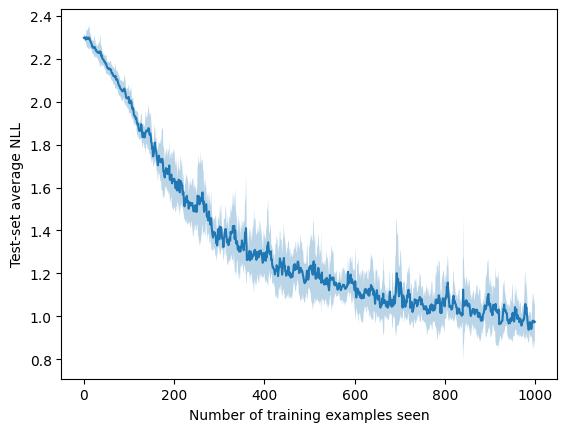

In [115]:
fig, ax = plt.subplots()
ax.plot(fdekf_mean)
ax.fill_between(
    jnp.arange(fdekf_mean.shape[0]),
    fdekf_mean - fdekf_std,
    fdekf_mean + fdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

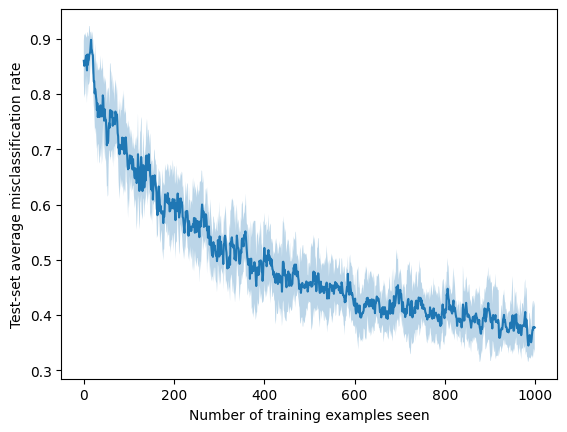

In [116]:
fig, ax = plt.subplots()
ax.plot(fdekf_miscl_mean)
ax.fill_between(
    jnp.arange(fdekf_miscl_mean.shape[0]),
    fdekf_miscl_mean - fdekf_miscl_std,
    fdekf_miscl_mean + fdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 6. VD-EKF

## 6.1 Hyperparam Tuning

In [120]:
vdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='vdekf')
vdekf_optimizer = BayesianOptimization(
    f=vdekf_opt_fn,
    pbounds={
        'log_init_cov': (-8, 0),
        'log_dynamics_cov': (-8, 0),
        'log_alpha': (-8, 0),
    }
)

In [121]:
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -1.429    | -7.587    | -3.85     | -5.802    |
| 2         | -1.72     | -3.153    | -2.543    | -3.528    |
| 3         | -1e+06    | -0.8081   | -1.443    | -3.674    |
| 4         | -2.384    | -4.856    | -2.085    | -5.662    |
| 5         | -2.066    | -6.362    | -5.637    | -7.978    |
| 6         | -2.289    | -2.39     | -7.742    | -6.138    |
| 7         | -2.465    | -6.859    | -1.439    | -2.346    |
| 8         | -1e+06    | -0.711    | -1.044    | -1.215    |
| 9         | -1.476    | -3.946    | -4.266    | -7.513    |
| 10        | -1e+06    | -0.7897   | -0.6959   | -6.423    |
| 11        | -2.175    | -6.463    | -6.046    | -3.814    |
| 12        | -1e+06    | -0.1361   | -0.5889   | -3.29     |
| 13        | -2.413    | -1.504    | -3.494    | -6.558    |
| 14        | -2.143    | -2.041    | -7.326    | -7.178    |
| 15    

In [128]:
# 'log_alpha': -7.714660864399069, 'log_dynamics_cov': -6.023213317381655, 'log_init_cov': -1.118170933013153
print(vdekf_optimizer.max)

{'target': -1.1800767183303833, 'params': {'log_alpha': -7.714660864399069, 'log_dynamics_cov': -6.023213317381655, 'log_init_cov': -1.118170933013153}}


## 6.2 Test-Set NLL Evaluation

In [117]:
init_cov = jnp.power(10, -1.118170933013153)
dynamics_cov = jnp.power(10, -6.023213317381655)
alpha = jnp.power(10, -7.714660864399069)
method = 'vdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
vdekf_estimator = RebayesEKF(model_params, method=method)

In [118]:
vdekf_mean, vdekf_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs)

In [119]:
vdekf_miscl_mean, vdekf_miscl_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations:  30%|███       | 300/1000 [00:08<00:20, 33.86it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:31<00:00, 31.47it/s]


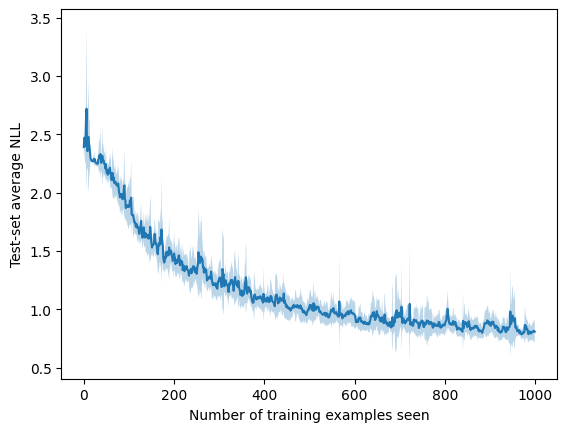

In [120]:
fig, ax = plt.subplots()
ax.plot(vdekf_mean)
ax.fill_between(
    jnp.arange(vdekf_mean.shape[0]),
    vdekf_mean - vdekf_std,
    vdekf_mean + vdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

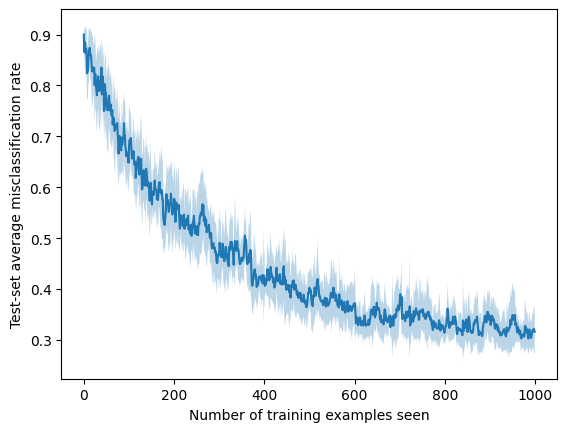

In [121]:
fig, ax = plt.subplots()
ax.plot(vdekf_miscl_mean)
ax.fill_between(
    jnp.arange(vdekf_miscl_mean.shape[0]),
    vdekf_miscl_mean - vdekf_miscl_std,
    vdekf_miscl_mean + vdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 7. Vanilla SGD

## 7.1 Hyperparam Tuning

In [140]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [141]:
def train_and_evaluate_model(state, X_train, y_train, evaluate_fn=evaluate_neg_log_likelihood):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
        nll = evaluate_fn(state.params, unflatten_fn, apply_fn, test_ds)
        
        return state, nll
    
    state, nlls = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state, nlls

In [142]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.power(10, log_lr))
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    _, nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

    result = nlls.mean()
    
    if jnp.isnan(result):
        result = 1e6
    return -result

In [143]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-8.0, 0.0)}
)

In [144]:
sgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -2.297    | -6.385    |
| 2         | -1.264    | -1.316    |
| 3         | -2.425    | -0.3499   |
| 4         | -2.15     | -3.269    |
| 5         | -2.293    | -4.921    |
| 6         | -1.596    | -2.608    |
| 7         | -2.215    | -3.517    |
| 8         | -2.351    | -0.6234   |
| 9         | -2.298    | -0.731    |
| 10        | -2.297    | -6.858    |
| 11        | -2.293    | -4.826    |
| 12        | -2.297    | -7.476    |
| 13        | -2.273    | -4.078    |
| 14        | -2.295    | -5.186    |
| 15        | -2.29     | -4.645    |
| 16        | -2.277    | -4.166    |
| 17        | -2.297    | -5.811    |
| 18        | -2.297    | -6.655    |
| 19        | -2.296    | -5.676    |
| 20        | -1.257    | -1.171    |
| 21        | -1.283    | -1.18     |
| 22        | -1.596    | -2.608    |
| 23        | -1.288    | -1.496    |
| 24        | -1.351    | -1.023    |
| 25        

In [145]:
# log_lr: -1.1709656254044134
print(sgd_optimizer.max)

{'target': -1.2565094232559204, 'params': {'log_lr': -1.1709656254044134}}


## 7.2 Test-Set NLL Evaluation

In [146]:
def evaluate_model_sgd(state, X, y, key=0, n_steps=1_000, n_iter=10, evaluate_fn=evaluate_neg_log_likelihood):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = train_and_evaluate_model(state, X_curr, y_curr, evaluate_fn=evaluate_fn)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [147]:
log_lr = -1.1709656254044134

tx = optax.sgd(jnp.power(10, log_lr))
opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
# _, sgd_nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

In [148]:
sgd_mean, sgd_std = evaluate_model_sgd(opt_state, X_train, y_train)

In [149]:
sgd_miscl_mean, sgd_miscl_std = evaluate_model_sgd(opt_state, X_train, y_train, evaluate_fn=evaluate_miscl)

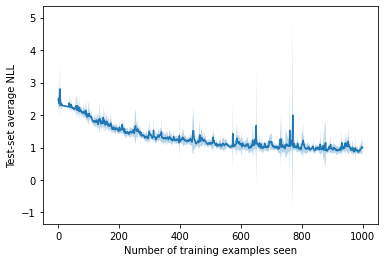

In [150]:
fig, ax = plt.subplots()
ax.plot(sgd_mean)
ax.fill_between(
    jnp.arange(sgd_mean.shape[0]),
    sgd_mean - sgd_std,
    sgd_mean + sgd_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

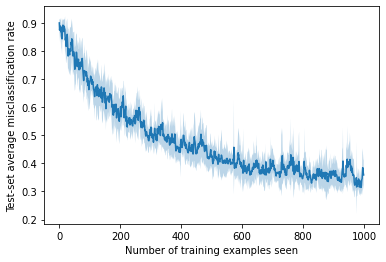

In [151]:
fig, ax = plt.subplots()
ax.plot(sgd_miscl_mean)
ax.fill_between(
    jnp.arange(sgd_miscl_mean.shape[0]),
    sgd_miscl_mean - sgd_miscl_std,
    sgd_miscl_mean + sgd_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 8. Replay-Buffer SGD

## 8.1 Hyperparam Tuning

In [84]:
@partial(jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    logits = vmap(applyfn, (None, 0))(params, X)
    nll = optax.softmax_cross_entropy(logits=logits, labels=y)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss

In [86]:
def rsgd_opt_fn(log_lr, n_inner):
    tx = optax.sgd(jnp.power(10, log_lr))
    rsgd_state = rsgd.FifoTrainState.create(
        apply_fn=apply_fn,
        params=flat_params,
        tx=tx,
        buffer_size=20,
        dim_features=[1, 28, 28, 1],
        dim_output=10,
    )
    estimator = rsgd.FSGD(lossfn_fifo, n_inner=int(n_inner))
    
    _, nlls = estimator.scan(X_train[:1000], y_train_ohe[:1000], bel=rsgd_state, callback=nll_callback, **test_kwargs)
    
    result = -nlls.mean()
    if jnp.isnan(result):
        result = -1e6
    
    return result
    

In [87]:
rsgd_pbounds = {
    'log_lr': (-8.0, 0.0),
    'n_inner': (1, 100),
}

rsgd_optimizer = BayesianOptimization(
    f=rsgd_opt_fn,
    pbounds=rsgd_pbounds,
)

In [88]:
rsgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 1         | -2.486    | -2.333    | 93.09     |
| 2         | -2.615    | -2.446    | 93.89     |
| 3         | -2.269    | -7.216    | 84.74     |
| 4         | -1.778    | -3.79     | 13.99     |
| 5         | -2.968    | -1.637    | 80.9      |
| 6         | -2.246    | -3.894    | 32.1      |
| 7         | -2.811    | -3.014    | 90.01     |
| 8         | -2.383    | -1.957    | 80.04     |
| 9         | -2.187    | -2.56     | 21.07     |
| 10        | -2.254    | -6.687    | 37.91     |
| 11        | -2.295    | -7.946    | 28.7      |
| 12        | -2.969    | -3.59     | 72.97     |
| 13        | -2.144    | -1.845    | 38.57     |
| 14        | -2.291    | -6.862    | 8.213     |
| 15        | -2.22     | -2.811    | 14.81     |
| 16        | -2.296    | -7.668    | 9.162     |
| 17        | -2.744    | -4.086    | 78.42     |
| 18        | -2.405    | -2.186    | 74.25     |


In [89]:
# 'log_lr': -4.022646243649376, 'n_inner': 3.678880065234039
print(rsgd_optimizer.max)

{'target': -1.2859745025634766, 'params': {'log_lr': -4.022646243649376, 'n_inner': 3.678880065234039}}


## 8.2 Test-Set NLL Evaluation

In [91]:
log_lr = -4.022646243649376
n_inner = int(3.678880065234039)

tx = optax.sgd(jnp.power(10, log_lr))
rsgd_state = rsgd.FifoTrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=tx,
    buffer_size=20,
    dim_features=[1, 28, 28, 1],
    dim_output=10,
)
rsgd_estimator = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)

In [92]:
rsgd_mean, rsgd_std = evaluate_model(rsgd_estimator, X_train, y_train_ohe, test_kwargs, bel=rsgd_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:34<00:00, 29.34it/s]


In [94]:
rsgd_miscl_mean, rsgd_miscl_std = evaluate_model(rsgd_estimator, X_train, y_train_ohe, test_kwargs, bel=rsgd_state, callback=miscl_callback)

Running for 1,000 iterations:  85%|████████▌ | 850/1000 [00:27<00:05, 29.58it/s]

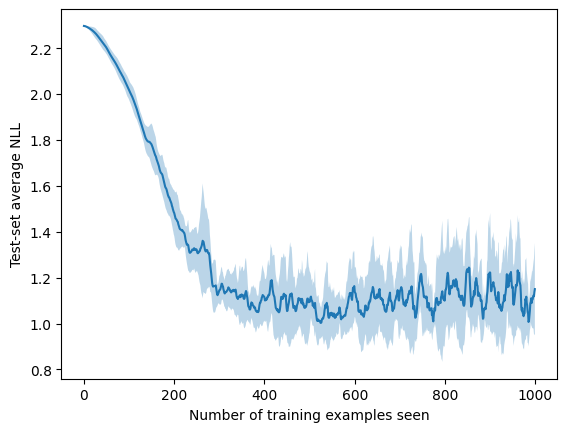

In [100]:
fig, ax = plt.subplots()
ax.plot(rsgd_mean)
ax.fill_between(
    jnp.arange(rsgd_mean.shape[0]),
    rsgd_mean - rsgd_std,
    rsgd_mean + rsgd_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

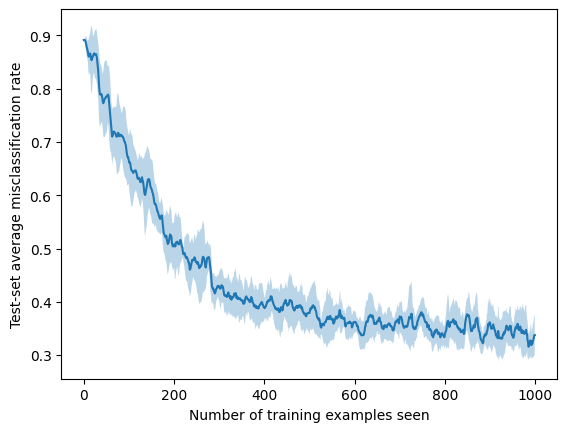

In [101]:
fig, ax = plt.subplots()
ax.plot(rsgd_miscl_mean)
ax.fill_between(
    jnp.arange(rsgd_miscl_mean.shape[0]),
    rsgd_miscl_mean - rsgd_miscl_std,
    rsgd_miscl_mean + rsgd_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 9. Model Comparison

In [122]:
results = {
    'rsgd': (rsgd_mean, rsgd_std),
    'fdekf': (fdekf_mean, fdekf_std),
    'vdekf': (vdekf_mean, vdekf_std),
    'os_lofi': (os_lofi_mean, os_lofi_std),
    'fs_lofi': (fs_lofi_mean, fs_lofi_std),
    'g_lofi': (g_lofi_mean, g_lofi_std),
}

In [123]:
results_miscl = {
    'rsgd': (rsgd_miscl_mean, rsgd_miscl_std),
    'fdekf': (fdekf_miscl_mean, fdekf_miscl_std),
    'vdekf': (vdekf_miscl_mean, vdekf_miscl_std),
    'os_lofi': (os_lofi_miscl_mean, os_lofi_miscl_std),
    'fs_lofi': (fs_lofi_miscl_mean, fs_lofi_miscl_std),
    'g_lofi': (g_lofi_miscl_mean, g_lofi_miscl_std),
}

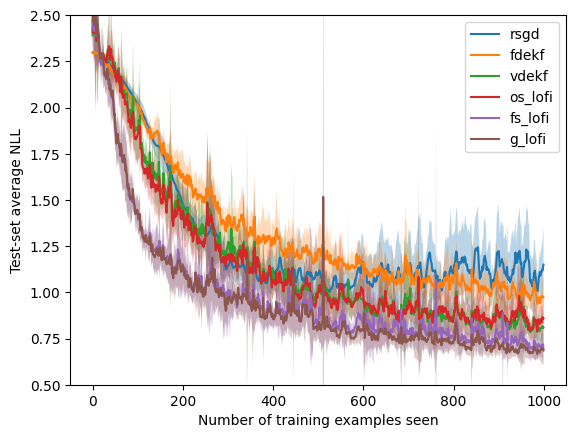

In [124]:
fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.5, 2.5)
ax.legend();

In [125]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.5, 2.5)
ax.legend();

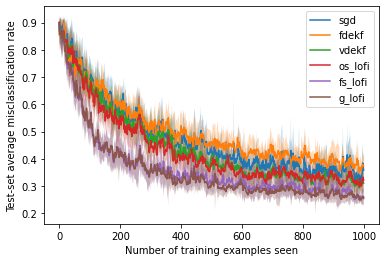

In [ ]:
fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.legend();

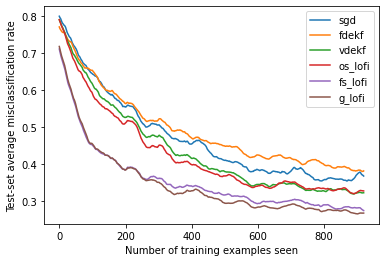

In [ ]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.legend();